# Summary:
The notebook combines several key steps in an end-to-end sentiment analysis pipeline:
1.	Tweet ingestion: Fetches tweets using an X Developers API
2.	Data processing: Cleans the data and structures it in a tabular format by saving it to a CSV file.
3.	Sentiment modeling: Applies machine learning techniques to classify tweet sentiments.
4.	Model interpretability: Uses LIME and SHAP to interpret predictions and highlight which words or features influence the sentiment decision.


# Tweets related to Hurricane are fetched from X (Twitter) and saved in 'Hurricane_tweets.csv' file.

In [ ]:
!pip install tweepy azure-eventhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.1/325.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 kB 12.8 MB/s eta 0:00:00


In [ ]:
import tweepy
import pandas as pd
from datetime import datetime, timedelta

# X (Twitter) API credentials
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAEUEvQEAAAAA91EzMqZ1fOw5clRvPZBQUE1ID5Y%3DRjLgpgwPJ4Dc6w01CDU1ZDrZRAW6lHI1GA7EvtQzG39tc3YcF7'

client = tweepy.Client(bearer_token=bearer_token)

# Defined the date range
current_time = datetime.utcnow()
end_time = (current_time - timedelta(minutes=1)).strftime('%Y-%m-%dT%H:%M:%SZ')  # 1 minute ago
start_time = (current_time - timedelta(days=2)).strftime('%Y-%m-%dT%H:%M:%SZ')   # 2 days ago

# Query for hurricane-related tweets
query = "Hurricane -is:retweet"
max_results = 100
next_token = None

# Created an empty list to hold tweet data
tweets_data = []

# To fetch tweets using pagination
while True:
    # Fetching tweets from X(Twitter)
    try:
        tweets = client.search_recent_tweets(query=query, max_results=max_results, next_token=next_token, start_time=start_time, end_time=end_time)
    except tweepy.TweepyException as e:
        print(f"Error fetching tweets: {e}")
        break

    # If no data, break the loop
    if not tweets.data:
        break

    # To process each tweet
    for tweet in tweets.data:
        tweet_info = {
            'tweet_id': tweet.id,
            'text': tweet.text,
            'created_at': tweet.created_at,
            'author_id': tweet.author_id
        }
        tweets_data.append(tweet_info)

    # To get the next_token for pagination
    next_token = tweets.meta.get('next_token', None)

    # If there's no next_token, exit the loop
    if next_token is None:
        break

# To convert list of tweets to a pandas DataFrame
df = pd.DataFrame(tweets_data)

# Saved the DataFrame to a .csv file
csv_file = "hurricane_tweets.csv"
df.to_csv(csv_file, index=False, encoding='utf-8')

print(f"Successfully saved {len(df)} tweets to {csv_file}")

Error fetching tweets: 429 Too Many Requests
Usage cap exceeded: Monthly product cap
Successfully saved 3394 tweets to hurricane_tweets.csv


429 Too Many Requests: The Twitter API is rate-limited, meaning we can only make a certain number of requests within a given time window . Once this limit is hit, we must wait before making further requests.

# Modified coding to avoid reaching rate limit

In [ ]:
import tweepy
import pandas as pd
from datetime import datetime, timedelta
import time

# Twitter API credentials
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAEUEvQEAAAAA91EzMqZ1fOw5clRvPZBQUE1ID5Y%3DRjLgpgwPJ4Dc6w01CDU1ZDrZRAW6lHI1GA7EvtQzG39tc3YcF7'

# Set up Twitter API v2 client
client = tweepy.Client(bearer_token=bearer_token)

# Defined the date range (using a start time at least several hours ago)
current_time = datetime.utcnow()
end_time = (current_time - timedelta(minutes=1)).strftime('%Y-%m-%dT%H:%M:%SZ')  # 1 minute ago
start_time = (current_time - timedelta(days=2)).strftime('%Y-%m-%dT%H:%M:%SZ')   # 2 days ago

# Query for hurricane-related tweets
query = "Hurricane -is:retweet"
max_results = 100
next_token = None

# Created an empty list to hold tweet data
tweets_data = []

def handle_rate_limit():
    """Pause execution when the rate limit is reached."""
    print("Rate limit reached. Waiting for 15 minutes before retrying...")
    time.sleep(15 * 60)  # Sleep for 15 minutes

# To fetch tweets using pagination
while True:
    try:
        # To fetch tweets from Twitter
        tweets = client.search_recent_tweets(query=query, max_results=max_results, next_token=next_token, start_time=start_time, end_time=end_time)
    except tweepy.TooManyRequests:
        handle_rate_limit()
        continue  # To retry after waiting
    except tweepy.TweepyException as e:
        print(f"Error fetching tweets: {e}")
        break

    # If no data, break the loop
    if not tweets.data:
        break

    # Processes each tweet
    for tweet in tweets.data:
        tweet_info = {
            'tweet_id': tweet.id,
            'text': tweet.text,
            'created_at': tweet.created_at,
            'author_id': tweet.author_id
        }
        tweets_data.append(tweet_info)

    # To get the next_token for pagination
    next_token = tweets.meta.get('next_token', None)

    # If there's no next_token, exit the loop
    if next_token is None:
        break

# Converts list of tweets to a pandas DataFrame
df = pd.DataFrame(tweets_data)

# Saved the DataFrame to a .csv file
csv_file = "hurricane_tweets.csv"
df.to_csv(csv_file, index=False, encoding='utf-8')

print(f"Successfully saved {len(df)} tweets to {csv_file}")


### Rate Limit Handling:
The handle_rate_limit() function pauses the script for 15 minutes when the 429 Too Many Requests error is encountered. After waiting, the script will automatically resume fetching tweets.
### Retry Logic:
When the 429 error is caught, the program waits and retries fetching tweets, ensuring not to miss any tweets when the rate limit resets.
### Final Note:
This logic helps to gather tweets over a longer time span without having to restart the program manually after hitting the rate limit. We can run the script again if we need more tweets or wait for the next rate limit reset.


# 'Hurricane_tweets.csv' dataset will be analysed

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [ ]:
import pandas as pd

# Loaded the hurricane tweets dataset
file_path = '/content/hurricane_tweets.csv'
ht = pd.read_csv(file_path)

# Displayed the first few rows of the dataset to understand its structure
ht.head()

,tweet_id,text,created_at,author_id
0,1837074300496498829,@RickTompkins @MelissaF1711 @Hurricane_Stacy @...,NaN,NaN
1,1837074287951262065,"""From the calm before the storm to the eye of ...",NaN,NaN
2,1837074248533217534,"🌍 The climate crisis is real, and Hurricane Be...",NaN,NaN
3,1837074218451693935,REST IN PEACE TO THE 4645+ WHO LOST THEIR LIVE...,NaN,NaN
4,1837074178232483935,@SCweather_wx need to monitor the Caribbean go...,NaN,NaN


In [ ]:
ht.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    3394 non-null   int64  
 1   text        3394 non-null   object 
 2   created_at  0 non-null      float64
 3   author_id   0 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 106.2+ KB


In [ ]:
# Checks for missing values
missing_values = ht.isnull().sum()

# The heatmap shows the columns with missing values. It appears that the created_at and author_id columns have missing data for many records.

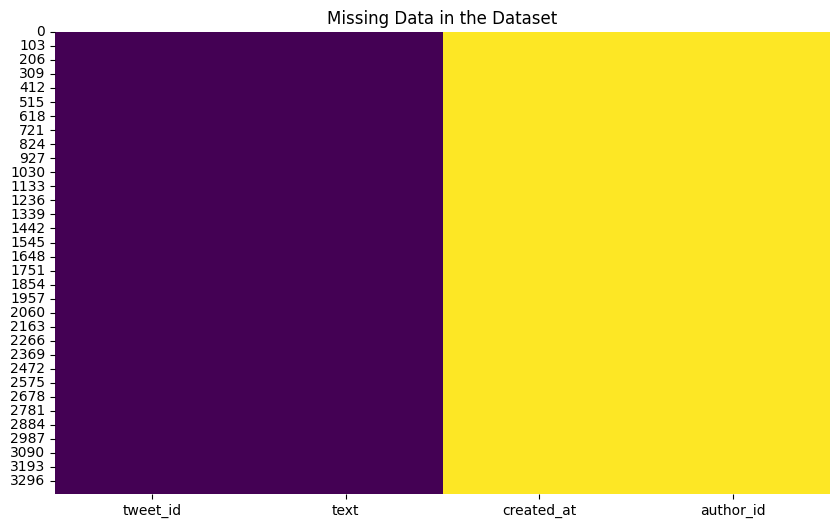

In [ ]:
# Visualised missing data
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data in the Dataset')
plt.show()

# The Word Cloud generated from the tweet texts highlights the most common words used in the dataset.

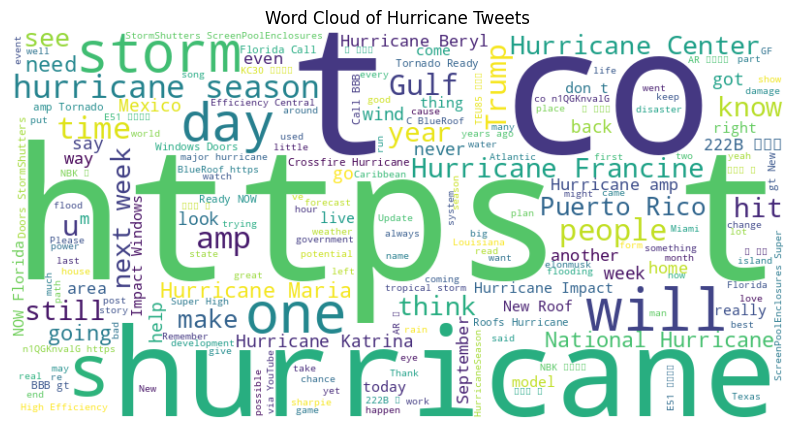

In [ ]:
# Word Cloud for the most frequent words in the tweet text
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df['text'].astype(str)))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hurricane Tweets')
plt.show()

#Sentiment Polarity Distribution:
The first plot shows the distribution of sentiment polarity across the tweets. Polarity ranges from -1 (negative) to +1 (positive).
# Subjectivity Distribution:
The second plot displays the subjectivity of the tweets. Subjectivity ranges from 0 (objective) to 1 (subjective).
## Additionally, two new columns are added to the dataset:

polarity: Sentiment polarity of each tweet.
subjectivity: Subjectivity of each tweet.

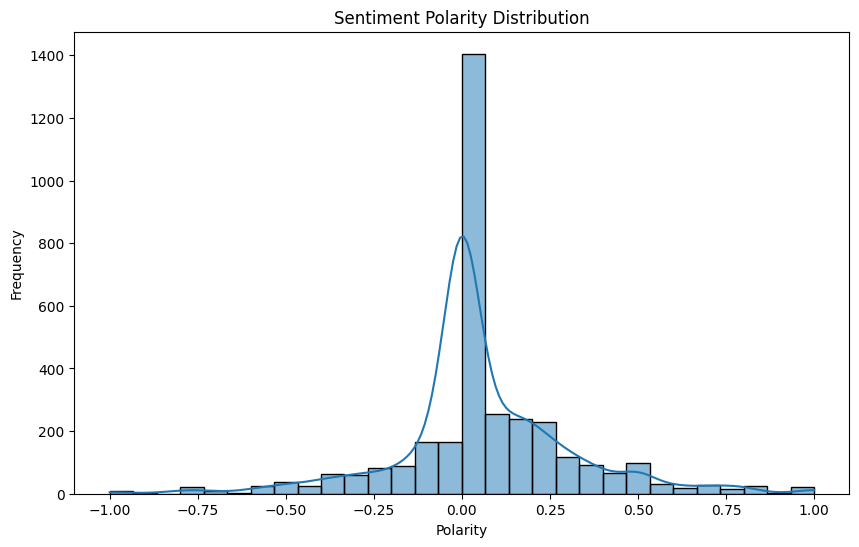

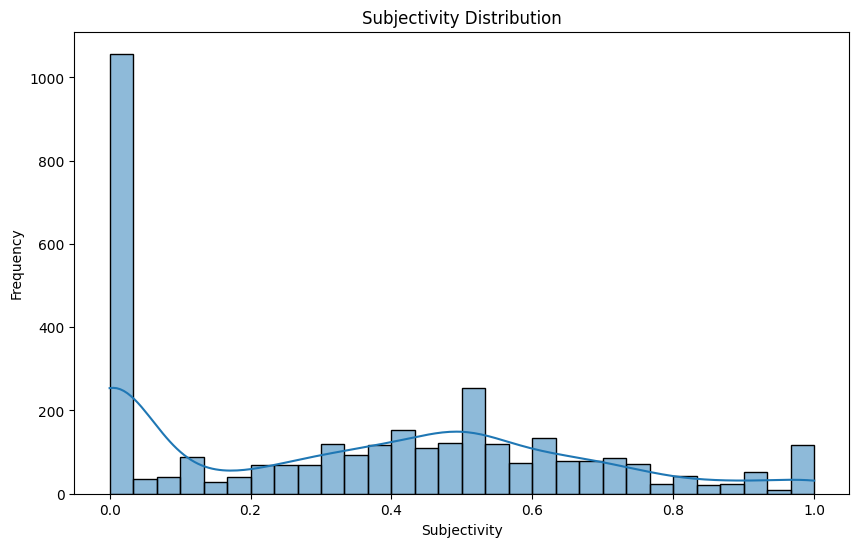

,text,polarity,subjectivity
0,@RickTompkins @MelissaF1711 @Hurricane_Stacy @...,0.55000,0.700000
1,"""From the calm before the storm to the eye of ...",0.31875,0.662500
2,"🌍 The climate crisis is real, and Hurricane Be...",-0.35000,0.566667
3,REST IN PEACE TO THE 4645+ WHO LOST THEIR LIVE...,0.00000,0.000000
4,@SCweather_wx need to monitor the Caribbean go...,0.10000,0.300000


In [ ]:
from textblob import TextBlob

# Function to calculate sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# To apply sentiment analysis to each tweet
df['polarity'], df['subjectivity'] = zip(*df['text'].apply(get_sentiment))

# Visualised the distribution of sentiment polarity
plt.figure(figsize=(10,6))
sns.histplot(df['polarity'], bins=30, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

# Visualised the distribution of subjectivity
plt.figure(figsize=(10,6))
sns.histplot(df['subjectivity'], bins=30, kde=True)
plt.title('Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()

# Displayed the first few rows with sentiment columns added
df[['text', 'polarity', 'subjectivity']].head()

# Donut chart:
The donut chart displays the distribution of positive, negative, and neutral tweets based on the sentiment analysis. This visualization helps in understanding the overall sentiment polarity of the tweets in a dataset.
# The tweets are classified as positive, negative, or neutral based on their polarity values, and the Donut chart shows the distribution of these sentiment categories.

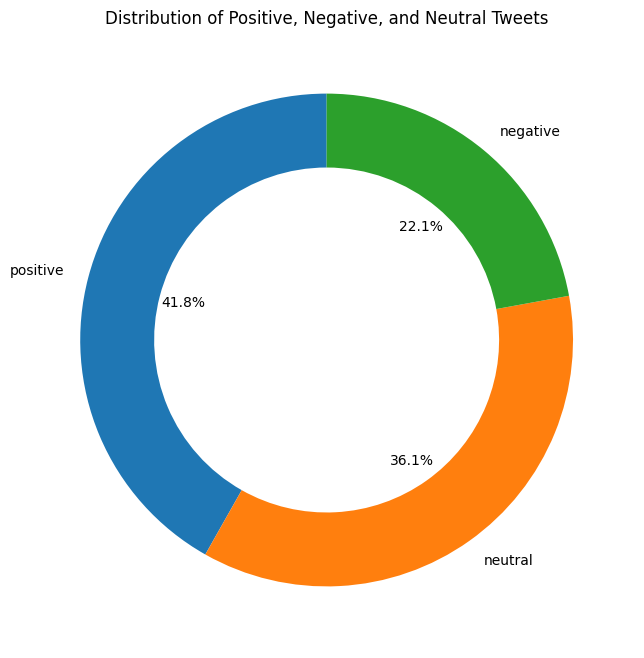

In [ ]:
# To classify tweets as positive, negative, or neutral based on polarity
df['sentiment'] = df['polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Counts the number of positive, negative, and neutral tweets
sentiment_counts = df['sentiment'].value_counts()

# Created a donut chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.3})
plt.title('Distribution of Positive, Negative, and Neutral Tweets')
plt.show()

In [ ]:
# To get the counts for each sentiment category (positive, negative, neutral)
total_tweets = len(df)
positive_tweets = sentiment_counts['positive']
negative_tweets = sentiment_counts['negative']
neutral_tweets = sentiment_counts['neutral']

# To display the numbers
total_tweets, positive_tweets, negative_tweets, neutral_tweets

(3394, 1419, 751, 1224)

# BERT Model

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 13.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


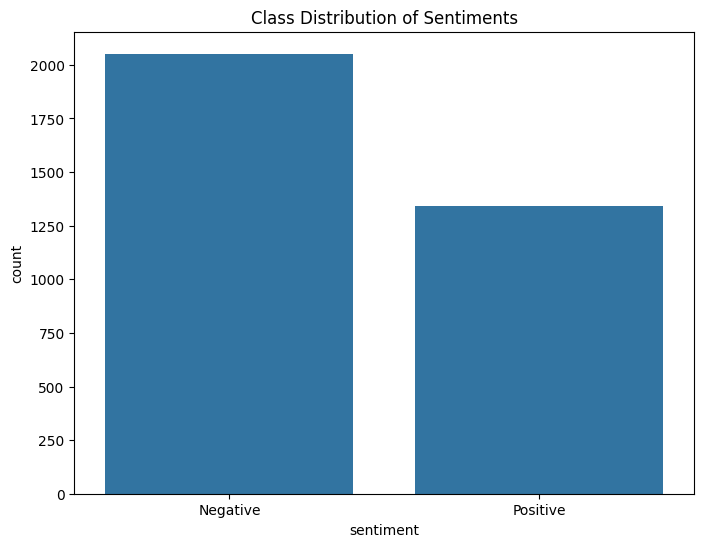

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Test Accuracy: 73.20%


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:59:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:00:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:01:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:02:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation Accuracy: 77.49%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.80      0.79       424
    Positive       0.65      0.62      0.64       255

    accuracy                           0.73       679
   macro avg       0.71      0.71      0.71       679
weighted avg       0.73      0.73      0.73       679



In [ ]:
import pandas as pd
import re
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling

# Defined stopwords
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it',
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
    'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no',
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
    'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't",
    'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
    'won', "won't", 'wouldn', "wouldn't"
])

# Text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()  # Lowercase
    words = text.split()  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Loads the dataset
file_path = '/content/hurricane_tweets.csv'
hurricane_tweets_df = pd.read_csv(file_path)

# Applying text cleaning
hurricane_tweets_df['clean_text'] = hurricane_tweets_df['text'].apply(clean_text)

# Sentiment analysis using TextBlob to generate polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

hurricane_tweets_df['polarity'] = hurricane_tweets_df['clean_text'].apply(get_polarity)

# Binary sentiment classification: Positive (1) or Negative (0)
hurricane_tweets_df['sentiment'] = hurricane_tweets_df['polarity'].apply(lambda x: 1 if x > 0 else 0)

# Visualises class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=hurricane_tweets_df)
plt.title('Class Distribution of Sentiments')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Splits the data
X_train, X_test, y_train, y_test = train_test_split(hurricane_tweets_df['clean_text'], hurricane_tweets_df['sentiment'], test_size=0.2, random_state=42)

# Loads SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generates SBERT embeddings
X_train_embeddings = sbert_model.encode(X_train.tolist(), batch_size=16, show_progress_bar=True)
X_test_embeddings = sbert_model.encode(X_test.tolist(), batch_size=16, show_progress_bar=True)

# Handles class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_embeddings_resampled, y_train_resampled = smote.fit_resample(X_train_embeddings, y_train)

# Trains XGBoost model with class balancing
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,
                               learning_rate=0.01, max_depth=6, n_estimators=500)

# Trains the XGBoost model on the resampled (balanced) dataset
xgb_model.fit(X_train_embeddings_resampled, y_train_resampled)

# Predicts on the test set
y_pred_xgb = xgb_model.predict(X_test_embeddings)

# Evaluates the accuracy
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Test Accuracy: {xgb_accuracy * 100:.2f}%")

# Cross-validation
cross_val_scores = cross_val_score(xgb_model, X_train_embeddings_resampled, y_train_resampled, cv=5)
print(f"Cross-Validation Accuracy: {cross_val_scores.mean() * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Negative', 'Positive']))


# Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Applying SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_embeddings, y_train)

# Trains Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predicts on the test set
y_pred_rf = rf_model.predict(X_test_embeddings)

# Evaluates the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Model Test Accuracy: {rf_accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Negative', 'Positive']))


Random Forest Model Test Accuracy: 72.90%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.87      0.80       424
    Positive       0.69      0.50      0.58       255

    accuracy                           0.73       679
   macro avg       0.72      0.68      0.69       679
weighted avg       0.72      0.73      0.72       679



# Applying LIME for Interpretability

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ac0e9e3d4d66289f602da5ee29002b35e612a66a8dc084018f5a8cdddbc167a5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

# Uses LIME text explainer
explainer = lime.lime_text.LimeTextExplainer(class_names=['Negative', 'Positive'])

# Defines a function to predict the sentiment using the Random Forest model
def predict_proba_rf(texts):
    embeddings = sbert_model.encode(texts, batch_size=16, show_progress_bar=False)
    return rf_model.predict_proba(embeddings)

# Chooses a sample tweet to explain
sample_text = X_test.tolist()[0]
explanation = explainer.explain_instance(sample_text, predict_proba_rf)

# Displays the LIME explanation in the notebook
explanation.show_in_notebook(text=sample_text)

The LIME explanation output shown in the image provides insights into how the Random Forest model predicted the sentiment for a particular text. Here’s a breakdown of the elements:

1. Prediction Probabilities:
The bar on the left shows the model’s prediction probabilities:
Negative: The model predicted a 58% probability that the tweet is negative.
Positive: The model predicted a 42% probability that the tweet is positive.
Based on these probabilities, the model classified the tweet as negative, since 58% > 42%.
2. Words Impacting the Prediction:
The middle section lists the words that influenced the model's prediction.
Words are shown under two columns:
Negative (on the left): Words that push the prediction towards the negative class.
Positive (on the right): Words that push the prediction towards the positive class.
3. Highlighted Words:
The right side shows the text with highlighted words:
Orange: Words contributing to the positive class.
Blue: Words contributing to the negative class.
Hence,
LIME helps to show which words in the text are pushing the model's decision towards either the negative or positive class.


# Applying SHAP for Global and Local Interpretability

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.3 MB/s eta 0:00:00


 99%|===================| 1341/1358 [00:53<00:00]       

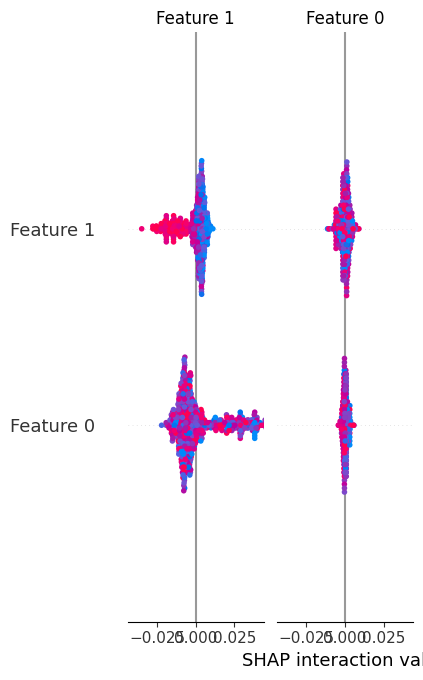

In [ ]:
import shap

# Initialises SHAP explainer
explainer_shap = shap.Explainer(rf_model, X_train_resampled)

# Explains the model's predictions for the test set
shap_values = explainer_shap(X_test_embeddings)

# Plots summary of SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test_embeddings)

# Explains a single prediction
shap.initjs()
